In [79]:
import numpy as np
import cv2
import os
import PIL 
import tensorflow as tf
import matplotlib.pyplot as plt
# from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers ,models
import numpy as np
from scipy.ndimage import gaussian_filter
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage.metrics import structural_similarity as compare_ssim
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.signal import wiener
from scipy import fftpack
from scipy.ndimage import gaussian_filter
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [80]:
def compute_ssim(image_path1, image_path2, win_size=7):
    try:
        img1 = io.imread(image_path1)
        img2 = io.imread(image_path2)

        if img1.shape != img2.shape:
            raise ValueError("Images must have the same dimensions for SSIM calculation.")

        # Ensure that win_size is an odd value less than or equal to the smaller side of the images
        win_size = min(win_size, min(img1.shape[0], img1.shape[1]))
        if win_size % 2 == 0:
            win_size += 1

        ssim = compare_ssim(img1, img2, multichannel=True, win_size=win_size)
        return ssim

    except (FileNotFoundError, ValueError, Exception) as e:
        print(f"An error occurred: {str(e)}")
        return None

In [81]:
def psnr(original, noisy):
    # Ensure both images have the same shape
    if original.shape != noisy.shape:
        raise ValueError("Both images must have the same dimensions.")

    # Calculate the mean squared error (MSE)
    mse = np.mean((original - noisy) ** 2)

    # Calculate the maximum possible pixel value (assumed to be 255 for 8-bit images)
    max_pixel_value = 255.0

    # Calculate PSNR
    psnr = 20 * math.log10(max_pixel_value / math.sqrt(mse))

    return psnr

In [82]:
def custom_mse_loss(y_true, y_pred):
    # Calculate the mean squared error
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    return mse

In [83]:
def loss(original,noisy):
    return compare_ssim(original, noisy, data_range=original.max()-original.min()),psnr(original, noisy),custom_mse_loss(original, noisy)

In [84]:
def Weiner_filter(original_image,noisy_image,std):
    # Add noise to the image
#     noise = np.random.normal(0, std, original_image.shape)
#     noisy_image = original_image + noise

    # Apply Wiener filter
    filtered_image = wiener(noisy_image, mysize=(3, 3))
    
    return original_image,noisy_image,filtered_image

In [85]:
def bilateral_filter(original_image,noisy_image,std):
    # Apply bilateral filter
    filtered_image = cv2.bilateralFilter(noisy_image, d=15, sigmaColor=15, sigmaSpace=18)
    
    return original_image,noisy_image,filtered_image

In [86]:
def filt(original_image,noisy_image,std):
    original,w_noisy,w_filtered = Weiner_filter(original_image,noisy_image,std)
    original,b_noisy,b_filtered = bilateral_filter(original_image,noisy_image,std)
    return original,w_noisy,w_filtered,b_noisy,b_filtered

In [87]:
def plot_image(std,original,noisy,predicted,a='Original',b='Nosiy',c='Predicted'):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title(a)
    plt.imshow(original,cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title(b)
    plt.imshow(noisy,cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title(c)
    plt.imshow(predicted,cmap='gray')
    plt.axis('off')
    plt.show()

In [88]:
def add_gaussian_noise(image, mean=0, stddev=25):
    noise = np.random.normal(mean, stddev, image.shape).astype('uint8')
    noisy_image = np.clip(image + noise, 0, 255)
    return noisy_image

def apply_gaussian_filter(image, sigma=1):
    filtered_image = gaussian_filter(image, sigma=sigma)
    return filtered_image

def apply_gaussian_filter_with_noise(image_path, noise_mean, noise_stddev, sigma):
    # Load the image using PIL
    image = cv2.imread(image_path)
#     image = image.reshape(-1,3044,/ 4048, 3)
    image = cv2.resize(image, (224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     image = image.reshape(-1,64,64,3)
    
    # Add Gaussian noise
    noisy_image = add_gaussian_noise(image, noise_mean, noise_stddev)

    # Apply Gaussian filter
    filtered_image = apply_gaussian_filter(noisy_image, sigma)

    return image,noisy_image, filtered_image

In [89]:
def create_data(file_path,std):
    x = []
    y = []
    
    for i in os.listdir(file_path):
        n=0
        for j in os.listdir(file_path+'//'+i):
            if n<80:
                noise_mean = 0  # Mean of Gaussian noise
                noise_stddev = std  # Standard deviation of Gaussian noise
                sigma = 1  # Sigma for the Gaussian filter
                image_path = file_path+'//'+i+'//'+j 
                image,noisy_image, filtered_image = apply_gaussian_filter_with_noise(image_path, noise_mean, noise_stddev, sigma)
                x.append(noisy_image)
                y.append(image)
                n+=1
            else:
                break
    return np.array(x),np.array(y)

In [90]:
def cnn_data(file_path,std):
    noise_mean = 0  # Mean of Gaussian noise
    noise_stddev = std  # Standard deviation of Gaussian noise
    sigma = 1  # Sigma for the Gaussian filter
    image_path = file_path 
    image,noisy_image, filtered_image = apply_gaussian_filter_with_noise(image_path, noise_mean, noise_stddev, sigma)
    return image,noisy_image,filtered_image

In [91]:
def dncnn_model(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Initial convolutional layer
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    
    # Stack of residual blocks
    for _ in range(15):
        residual = tf.keras.layers.Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
        x = tf.keras.layers.Add()([x, residual])
        x = tf.keras.layers.Activation('relu')(x)
    
    # Final convolutional layer
    outputs = tf.keras.layers.Conv2D(1, (3, 3), padding='same')(x)
    
    model = tf.keras.models.Model(inputs, outputs)
    return model

In [92]:
def predict_img(noisy_image,model):
    pred = noisy_image
    pred = pred.reshape(-1,224,224,1)
    predicted_image = model.predict(pred)
    return predicted_image

In [93]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pixel_count_vs_value(image1, image2, image3, image4,label1,label2,label3,label4, title="Pixel Count vs. Pixel Value"):
    # Flatten the images to 1D arrays
    flat1 = image1.flatten()
    flat2 = image2.flatten()
    flat3 = image3.flatten()
    flat4 = image4.flatten()

    # Create histograms for all four images
    hist1, bins1 = np.histogram(flat1, bins=256, range=(0, 256))
    hist2, bins2 = np.histogram(flat2, bins=256, range=(0, 256))
    hist3, bins3 = np.histogram(flat3, bins=256, range=(0, 256))
    hist4, bins4 = np.histogram(flat4, bins=256, range=(0, 256))

    # Plot the number of pixels (pixel count) versus pixel values for all four images
    plt.plot(bins1[:-1], hist1, label=label1, color='blue')
    plt.plot(bins2[:-1], hist2, label=label2, color='red')
    plt.plot(bins3[:-1], hist3, label=label3, color='green')
    plt.plot(bins4[:-1], hist4, label=label4, color='purple')

    # Set plot labels and title
    plt.xlabel('Pixel Value')
    plt.ylabel('Number of Pixels')
    plt.title(title)

    # Add a legend to the plot
    plt.legend(loc='upper right')

    # Display the plot
    plt.show()

# Example usage:
# Assuming you have four images: reference_image, noisy_image1, noisy_image2, noisy_image3
# plot_pixel_count_vs_value(reference_image, noisy_image1, noisy_image2, noisy_image3)


In [94]:
def plot_image(std,original,noisy,predicted,a='Original',b='Nosiy',c='Predicted'):
    plt.figure(figsize=(12, 6))
    print('σ-'+str(std))
    plt.subplot(1, 3, 1)
    plt.title(a)
    plt.imshow(original,cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(b)
    plt.imshow(noisy,cmap='gray')
    plt.axis('off')
    # test = x[i] - img
    plt.subplot(1, 3, 3)
    plt.title(c)
    plt.imshow(predicted,cmap='gray')
    plt.axis('off')
    plt.show()

In [95]:
def main(std_arr,original_image,cnn_path):
    for std in std_arr:
        
        print('σ-'+str(std))
        ## Model Train
        file_path = '/kaggle/input/flowers-recognition/flowers'
        x,y = create_data(file_path,std)
        input_shape = (224, 224, 1)  # Adjust the input shape to match your data
        model = dncnn_model(input_shape)
        model.compile(optimizer='adam', loss='mean_squared_error')
        batch_size = 32
        epochs = 200
        model.fit(x,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)
        
        original_image,noisy_image,filtered_image = cnn_data(cnn_path,std)
        cnn_filtered = predict_img(noisy_image,model)
        cnn_filtered = cnn_filtered.reshape(224,224)
        c_ssim,c_psnr,c_mse = loss(original_image,cnn_filtered)
        ## Filters
        SSIM =[]
        PSNR = []
        MSE = []
        indx = []
        original,w_noisy,w_filtered,b_noisy,b_filtered = filt(original_image,noisy_image,std)
        x_ssim,x_psnr,x_mse = loss(original,w_filtered)
        y_ssim,y_psnr,y_mse = loss(original,b_filtered)
        SSIM.append(x_ssim)
        SSIM.append(y_ssim)
        SSIM.append(c_ssim)
        PSNR.append(x_psnr)
        PSNR.append(y_psnr)
        PSNR.append(c_psnr)
        MSE.append(x_mse)
        MSE.append(y_mse)
        MSE.append(c_mse)
        indx.append('Weiner_filtered')
        indx.append('Bilateral_Filtered')
        indx.append('CNN')
        SSIM = np.array(SSIM)
        PSNR = np.array(PSNR)
        MSE = np.array(MSE)
        indx = np.array(indx)
        print('\n')
        print('σ-'+str(std))
        plot_image(std,original,w_noisy,w_filtered,'Original','Weiner_filtered')
        plot_image(std,original,b_noisy,b_filtered,'Original','Noisy','Bilateral_filtered')
        plot_image(std,original,noisy_image,cnn_filtered,'Original','Noisy','CNN_filtered')
        df = pd.DataFrame(SSIM,columns=['SSIM'])
        df['PSNR'] = PSNR
        df['MSE'] = MSE  
        df.index = indx
        plot_pixel_count_vs_value(original,w_filtered,b_filtered,cnn_filtered,'Original','Weiner_filtered','Bilateral_filtered','CNN_filtered')
#         plot_pixel_count_vs_value(original,b_filtered, title=str(str('Bilateral Filter with ')+"σ-"+str(std)))
#         plot_pixel_count_vs_value(original,cnn_filtered, title=str(str('CNN with ')+"σ-"+str(std)))
        print(df)
        print('\n')
    return model
#         torch.save(model, 'model'+std+'.pth')

Text(0.5, 1.0, 'Clean Image')

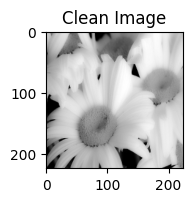

In [96]:
image = cv2.imread('/kaggle/input/flowers-recognition/flowers/daisy/11023214096_b5b39fab08.jpg')
image = cv2.resize(image, (224,224))
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(6,3))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Clean Image')

σ-10
Epoch 1/200
10/10 [==============================] - 10s 713ms/step - loss: 846146.8750 - val_loss: 1527.1394
Epoch 2/200
10/10 [==============================] - 7s 691ms/step - loss: 1718.3152 - val_loss: 1503.5795
Epoch 3/200
10/10 [==============================] - 7s 691ms/step - loss: 1483.1982 - val_loss: 1207.4640
Epoch 4/200
10/10 [==============================] - 7s 691ms/step - loss: 1157.5896 - val_loss: 950.9320
Epoch 5/200
10/10 [==============================] - 7s 691ms/step - loss: 978.6906 - val_loss: 757.0350
Epoch 6/200
10/10 [==============================] - 7s 692ms/step - loss: 855.1299 - val_loss: 537.8339
Epoch 7/200
10/10 [==============================] - 7s 691ms/step - loss: 684.0063 - val_loss: 523.7550
Epoch 8/200
10/10 [==============================] - 7s 691ms/step - loss: 609.2490 - val_loss: 415.2792
Epoch 9/200
10/10 [==============================] - 7s 691ms/step - loss: 610.3828 - val_loss: 546.2647
Epoch 10/200
10/10 [====================

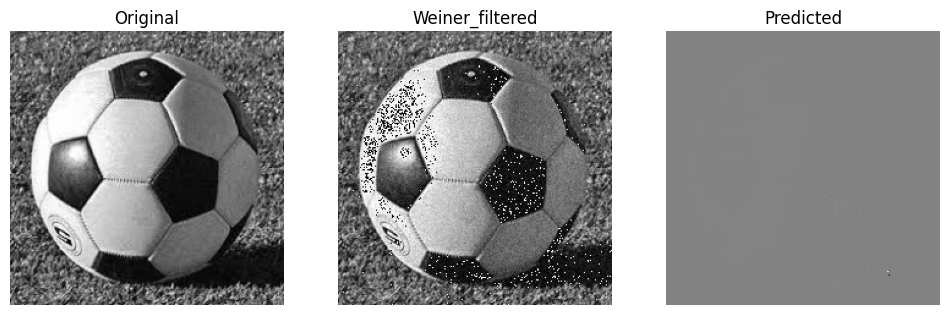

σ-10


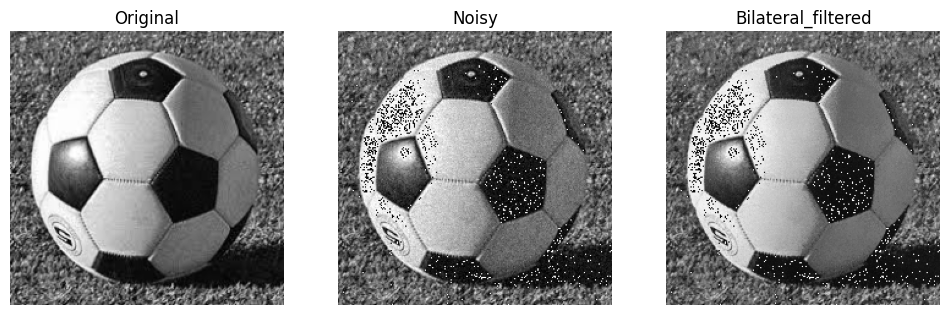

σ-10


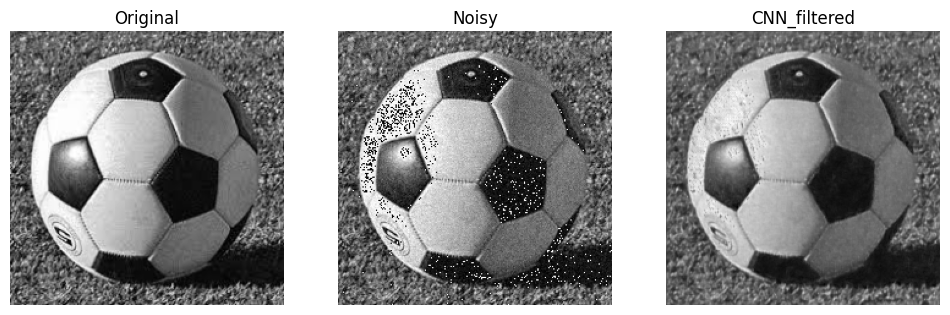

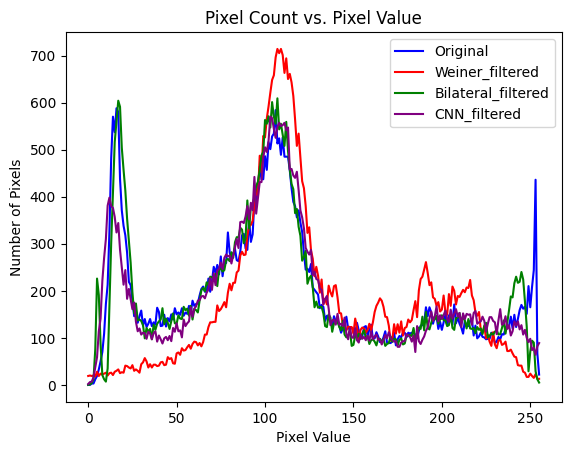

                        SSIM       PSNR            MSE
Weiner_filtered     0.309370  -9.967535  645407.324011
Bilateral_Filtered  0.727800  31.714258      43.000000
CNN                 0.842334  26.056037     161.241425




In [97]:
model = main([10],image,'/kaggle/input/image-denoising-1/download.jpeg')

In [99]:
model.save('gfgModel.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
